In [38]:
import numpy as np
import jax
import jax.numpy as jnp
import jimgw
import lal

In [39]:
import numpy as np

import os

os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false'
import optax
import corner
import matplotlib.pyplot as plt
import corner
import jax                                           
#jax.config.update('jax_platform_name', 'cpu')

import jax.numpy as jnp
from functools import partial

import distrax
import haiku as hk      #neural network library for JAX 
from typing import Any, Iterator, Mapping, Optional, Sequence, Tuple
Array = jnp.ndarray
PRNGKey = Array
OptState = Any


In [40]:
from interferometer import Interferometer
from scipy.interpolate import interp1d
import numpy as np
import jax.numpy as jnp
import gw
from matplotlib import pyplot as pl
import corner
import pickle
%matplotlib inline

In [47]:
f_min = 0. #minimum frequency cut-off
T = 1.  #data segment duration (8 seconds)
Fs = 100. #samplingfrequency  (Hz)
#t_start = 1126259446. #strain data segment start time 
t_start=0.
# since signals are generated in frequency domain this time is only used for calculating time dealys and hence is set to t_coalsecence

#initialise the detectors
H1_d = Interferometer('H1','O3',f_min,T,Fs,t_start,20011997)
L1_d = Interferometer('L1','O3',f_min,T,Fs,t_start,27071994)

In [48]:
def simulate_fd_sine_gaussian_waveform(A, t0, f0, tau, times, fmin, df):   #without phase for now
    
    t = times
    
    hpt = A*jnp.exp(-(t-t0)**2/tau**2)*jnp.cos(2*jnp.pi*f0*t) #time domain plus polarisation
    hct = A*jnp.exp(-(t-t0)**2/tau**2)*jnp.sin(2*jnp.pi*f0*t) #time domain cross polarisation

    hp = jnp.fft.rfft(hpt) #frequency domain plus polarisation
    hc = jnp.fft.rfft(hct) #frequency domain cross polarisation

    return hp, hc

In [49]:
def simulate_fd_sine_gaussian_waveform_matrix(A, t0, f0, tau, times, fmin, df):   #without phase for now
    
    t = times
    
    hpt = jnp.matmul(A.T,jnp.exp(-(t-t0)**2/tau**2)*jnp.cos(2*jnp.pi*f0*t)) #time domain plus polarisation
    hct = jnp.matmul(A.T,jnp.exp(-(t-t0)**2/tau**2)*jnp.sin(2*jnp.pi*f0*t)) #time domain cross polarisation

    hp = jnp.fft.rfft(hpt) #frequency domain plus polarisation
    hc = jnp.fft.rfft(hct) #frequency domain cross polarisation

    return hp, hc

[-6.68010092e-12+0.00000000e+00j -6.68231616e-12+1.04073097e-15j
 -6.67028932e-12-1.13110343e-15j -8.59393112e-12+1.08008426e-15j
  4.02891331e-11-6.17474079e-16j -1.01229608e-09+5.01296386e-16j
  1.75858280e-08-9.16200447e-16j -2.52729247e-07+1.27102615e-15j
  2.98003012e-06-1.89419530e-15j -2.88452453e-05+3.05141684e-15j
  2.29192394e-04-4.14483527e-15j -1.49485826e-03+4.27000156e-15j
  8.00338147e-03-2.94679072e-15j -3.51739164e-02+9.98913100e-16j
  1.26894162e-01+9.27229975e-16j -3.75782250e-01-1.90934966e-15j
  9.13491663e-01+1.35478079e-15j -1.82283190e+00+2.32330206e-16j
  2.98581129e+00-2.49227147e-15j -4.01468798e+00+4.80198103e-15j
  4.43113463e+00-5.33076654e-15j -4.01468798e+00+4.14243218e-15j
  2.98581129e+00-1.27437329e-15j -1.82283190e+00-2.07466555e-15j
  9.13491663e-01+4.65783565e-15j -3.75782250e-01-5.99520433e-15j
  1.26894162e-01+6.54500856e-15j -3.51739164e-02-6.77936307e-15j
  8.00338147e-03+6.21486575e-15j -1.49485826e-03-5.97430017e-15j
  2.29192394e-04+5.441788

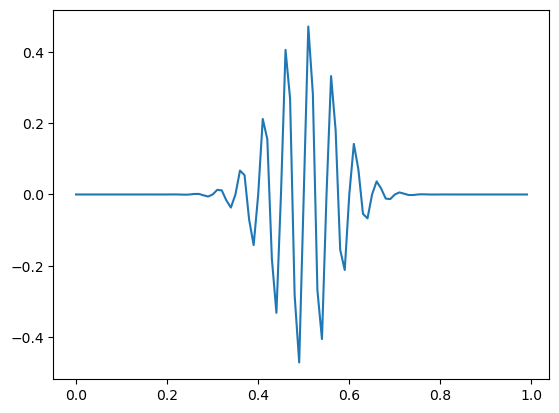

In [57]:
t=H1_d.times #time array for the time domain signal
A=0.5
t0=0.5
f0=20.
tau=2./f0
ra=0.5
dec=0.5
psi=0.5


simulate_fd_sine_gaussian_waveform(A, t0, f0, tau, t, f_min, H1_d.df)

#simulate signal 
hp, hc = simulate_fd_sine_gaussian_waveform(A,t0,f0,tau,t,0.,H1_d.df)
hct = jnp.fft.irfft(hc)
pl.plot(t,hct)
print(hp,hc)

In [59]:
from curses import KEY_REPLACE
import lalsimulation as lalsim 
import numpy as np
import jax.numpy as jnp
import jax

from jimgw.PE.detector_preset import * 
from jimgw.PE.detector_projection import make_detector_response

hp, hc = simulate_fd_sine_gaussian_waveform(A, t0, f0, tau, H1_d.times, f_min, H1_d.df)

H1 = get_H1()
H1_response = make_detector_response(H1[0], H1[1])   #detector_response(f, hp, hc, ra, dec, gmst, psi), strain in freq domain
L1 = get_L1()
L1_response = make_detector_response(L1[0], L1[1])   

gps = lal.LIGOTimeGPS(t0)
gmst_rad = lal.GreenwichMeanSiderealTime(gps)

#f_list = freqs[freqs>fmin]

L1_signal = L1_response(H1_d.freqs, hp, hc, ra, dec, gmst_rad, psi)   
H1_signal = H1_response(H1_d.freqs, hp, hc, ra, dec, gmst_rad, psi)  

H1_noise = 0
L1_noise = 0

#H1_noise = noise_fd_dict['H1'][freqs>fmin]
H1_data = H1_noise + H1_signal

#L1_noise = noise_fd_dict['L1'][freqs>fmin]
L1_data = L1_noise + L1_signal

response = {'H1': H1_response, 'L1': L1_response}


In [60]:
H1_signal, L1_signal

(Array([ 1.40988801e-12+0.00000000e+00j,  1.38251242e-12+3.92711905e-13j,
         1.28349292e-12+7.33723133e-13j,  1.07330048e-12+2.57561330e-12j,
         6.42038053e-12-3.52292639e-11j, -1.98105968e-10+7.68127249e-10j,
         4.86662132e-09-1.29690937e-08j, -8.90722152e-08+1.77968397e-07j,
         1.26474275e-06-1.97672062e-06j, -1.41824023e-05+1.77433094e-05j,
         1.26860181e-04-1.28376875e-04j, -9.10718892e-04+7.45856065e-04j,
         5.26807383e-03-3.45952718e-03j, -2.46202865e-02+1.26905768e-02j,
         9.31347769e-02-3.62089469e-02j, -2.85537661e-01+7.76925789e-02j,
         7.10102546e-01-1.14978491e-01j, -1.43323125e+00+7.94666269e-02j,
         2.34833979e+00+1.16918936e-01j, -3.12361826e+00-4.87700562e-01j,
         3.37210738e+00+8.97120517e-01j, -2.95302247e+00-1.12893807e+00j,
         2.09598928e+00+1.06545705e+00j, -1.20427106e+00-7.81151705e-01j,
         5.59093205e-01+4.52637236e-01j, -2.09183356e-01-2.09308902e-01j,
         6.28297421e-02+7.77019820e-02

In [61]:
def project_to_detector(detector, hp, hc, ra, dec, gmst_rad, psi):                   #unfix the frequency array?
    """Compute the response of the detector to incoming strain """
    return response[detector](H1_d.freqs, hp, hc, ra, dec, gmst_rad, psi)

In [62]:
test_params = dict(
        A = jnp.array([10.,2.]),
        ra=jnp.array([1.5,1.]),
        dec=jnp.array([0.5,0.8]),
        psi=jnp.array([1.0,1.5]))

In [63]:
true_params = dict(
        A=0.5,
        t0=0.5,
        f0=4.,
        tau=2./f0,
        ra=0.5,
        dec=0.5,
        psi=0.5)

detector = 'H1'
project_to_detector(detector, hp, hc, true_params['ra'], true_params['dec'], gmst_rad,  true_params['psi'] )

Array([ 1.40988801e-12+0.00000000e+00j,  1.38251242e-12+3.92711905e-13j,
        1.28349292e-12+7.33723133e-13j,  1.07330048e-12+2.57561330e-12j,
        6.42038053e-12-3.52292639e-11j, -1.98105968e-10+7.68127249e-10j,
        4.86662132e-09-1.29690937e-08j, -8.90722152e-08+1.77968397e-07j,
        1.26474275e-06-1.97672062e-06j, -1.41824023e-05+1.77433094e-05j,
        1.26860181e-04-1.28376875e-04j, -9.10718892e-04+7.45856065e-04j,
        5.26807383e-03-3.45952718e-03j, -2.46202865e-02+1.26905768e-02j,
        9.31347769e-02-3.62089469e-02j, -2.85537661e-01+7.76925789e-02j,
        7.10102546e-01-1.14978491e-01j, -1.43323125e+00+7.94666269e-02j,
        2.34833979e+00+1.16918936e-01j, -3.12361826e+00-4.87700562e-01j,
        3.37210738e+00+8.97120517e-01j, -2.95302247e+00-1.12893807e+00j,
        2.09598928e+00+1.06545705e+00j, -1.20427106e+00-7.81151705e-01j,
        5.59093205e-01+4.52637236e-01j, -2.09183356e-01-2.09308902e-01j,
        6.28297421e-02+7.77019820e-02j, -1.50593946

In [64]:
true_params = dict(
        A=0.5,
        t0=0.5,
        f0=4.,
        tau=2./f0,
        ra=0.5,
        dec=0.5,
        psi=0.5)

# likelihood function

class LogL(object):
    
    def __init__(self, true_gw_params):
        
        self.true_gw_params = true_gw_params
        self.detectors = {'H1': H1, 'L1': L1}
        
        gps_time = true_gw_params['t0']     #time of coalescence
        gps = lal.LIGOTimeGPS(gps_time)
        self.gmst_rad = lal.GreenwichMeanSiderealTime(gps)
        self.A = true_gw_params['A']
        self.t0 = true_gw_params['t0']
        self.f0 = true_gw_params['f0']
        self.tau = true_gw_params['tau']
        self.ra=true_gw_params['ra']
        self.dec = true_gw_params['dec']
        self.psi= true_gw_params['psi']

        self.f_min = 0.
        self.times = H1_d.times
        self.df = H1_d.df
        self.times2d = jnp.atleast_2d(H1_d.times)
   
        # simulate data
        #T = 1 # duration of analysis segment
        #srate = 20
        #df = 1/T
        #freqs = jnp.arange(1+srate*T, dtype=jnp.float32)*df
        #f0 = 100
        #Nbins = 1
        #i0 =int(f0/df)
        #self.freqs = jnp.atleast_2d(freqs[i0])

        #self.beta = 1/T

        #hp=true_gw_params['A']*jnp.cos(true_gw_params['phi'])     #plus polarisation
        #hc=true_gw_params['A']*jnp.sin(true_gw_params['phi'])    #cross polarisation
        
        self.hp, self.hc = simulate_fd_sine_gaussian_waveform(self.A, self.t0, self.f0, self.tau, H1_d.times, self.f_min, H1_d.df)
        self.data = self.simulate_response(self.hp, self.hc, self.ra, self.dec, self.psi)
        
        #self.bounds = dict(
        #    A = [self.true_params['A']*jnp.exp(-1), self.true_params['A']*jnp.exp(1)],
          #  phi = [-jnp.pi, jnp.pi],
         #  dec = [-jnp.pi/2, jnp.pi/2],
         #   ra = [0, jnp.pi*2],
         #   psi = [-jnp.pi/2, jnp.pi/2]
       # )

    def simulate_response_matrix(self, hp, hc, ra, dec, psi):
        # r = {d: project_to_detector(d, hp, hc, ra, dec, self.gmst_rad, psi) for d in self.detectors.keys()}
        r = {d: jnp.array([project_to_detector(d, hp[i], hc[i], ra[i], dec[i], self.gmst_rad, psi[i]) for i in range(len(ra))]) for d in self.detectors.keys()}
        return r
    
    def simulate_response(self, hp, hc, ra, dec, psi):
        r = {d: project_to_detector(d, hp, hc, ra, dec, self.gmst_rad, psi) for d in self.detectors.keys()}
        return r
    
    def __call__(self, params):
        hp, hc = simulate_fd_sine_gaussian_waveform(jnp.atleast_2d(params['A']).T, self.t0, self.f0, self.tau, self.times2d, self.f_min, self.df)
        # hp, hc = simulate_fd_sine_gaussian_waveform(params['A'], self.t0, self.f0, self.tau, self.times, self.f_min, self.df)
        
        #r = jnp.array([ self.simulate_response(hp, hc, params['ra'][i], params['dec'][i], params['psi'][i]) for i in range(len(params['ra']))])
        r = self.simulate_response_matrix(hp, hc, params['ra'], params['dec'], params['psi'])

        residuals = jnp.array([r[ifo] - self.data[ifo] for ifo in self.detectors.keys()])
        
        return -jnp.real(jnp.sum(residuals*jnp.conj(residuals),axis=(0,2)))/2

    @property
    def params(self):
        params = ['A','phi','dec','ra','psi']
        return params


    #@jax.jit
    def array_to_phys(self, x: Array) -> dict:
        
        p = dict()
        p['A'] = x[:,0]
        p['ra'] = x[:,1]
        p['dec'] = x[:,2]
        p['psi'] = x[:,3]

        return p

In [65]:
#Neural network setup

from vi_routines import make_flow_model

@hk.without_apply_rng
@hk.transform
def sample_and_log_prob(prng_key: PRNGKey, n: int) -> Tuple[Any, Array]:

    model = make_flow_model(                          #this is the flow distribution (a distrax object)
        event_shape=(n_params,),
        num_layers=flow_num_layers,
        hidden_sizes=[hidden_size] * mlp_num_layers,
        num_bins=num_bins
    )

    return model.sample_and_log_prob(seed=prng_key, sample_shape=(n,))
     # returns x (sample from the flow q), and model.log_prob(x) (array of log(q) of th sampled points)


def log_likelihood(x: Array) -> Array:      #transform to parameter space before c
    p = log_l.array_to_phys(x)
    return log_l(p) 

def loss_fn(params: hk.Params, prng_key: PRNGKey, n: int) -> Array:       #computes reverse KL-divergence for the sample x_flow between the flow and gw loglikelihood.

    x_flow, log_q = sample_and_log_prob.apply(params, prng_key, n)           #gets sample from the flow and computes log_q for the sampled points.
    log_p = log_likelihood(x_flow)
                                           #gets gw loglikelihood for the sampled points (after transforming them into physical space..)
    loss = jnp.mean(log_q - log_p)
    return loss

@jax.jit
def update(
    params: hk.Params,
    prng_key: PRNGKey,
    opt_state: OptState,
) -> Tuple[hk.Params, OptState]:
    """Single SGD update step."""
    grads = jax.grad(loss_fn)(params, prng_key, Nsamps)
    updates, new_opt_state = optimiser.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state

  0%|          | 0/100 [00:01<?, ?it/s, loss=117.06, T=1]

Epoch 0, loss 117.0606342832946


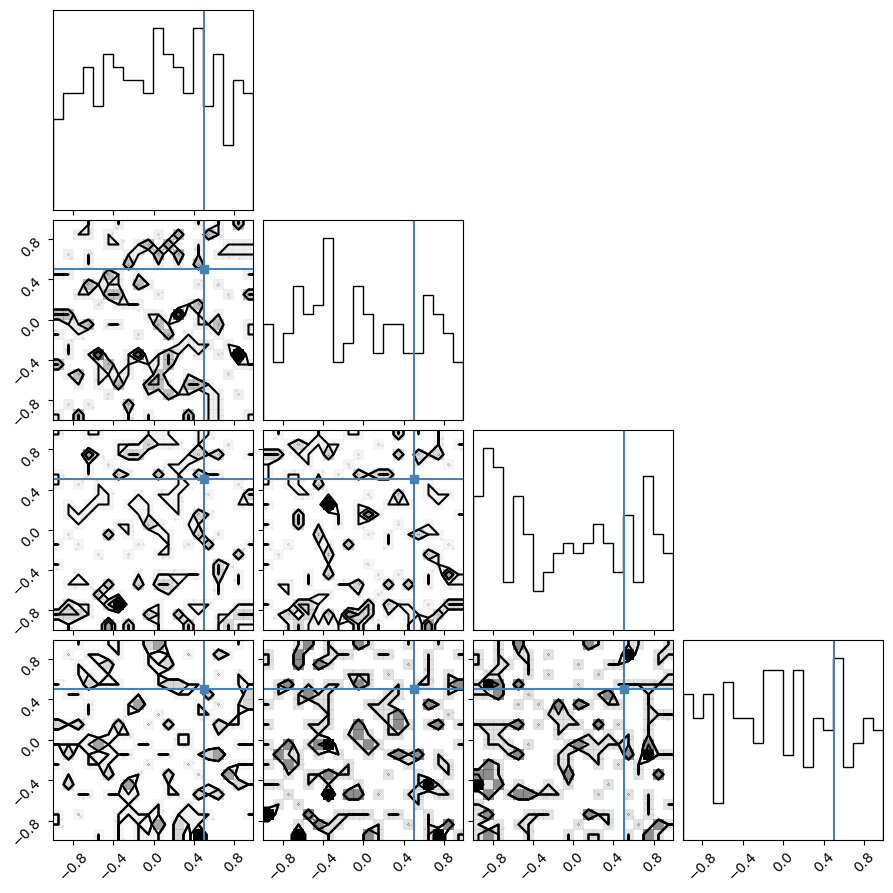

 50%|█████     | 50/100 [01:52<00:36,  1.37it/s, loss=14.78, T=1]  

Epoch 50, loss 14.77615523566197


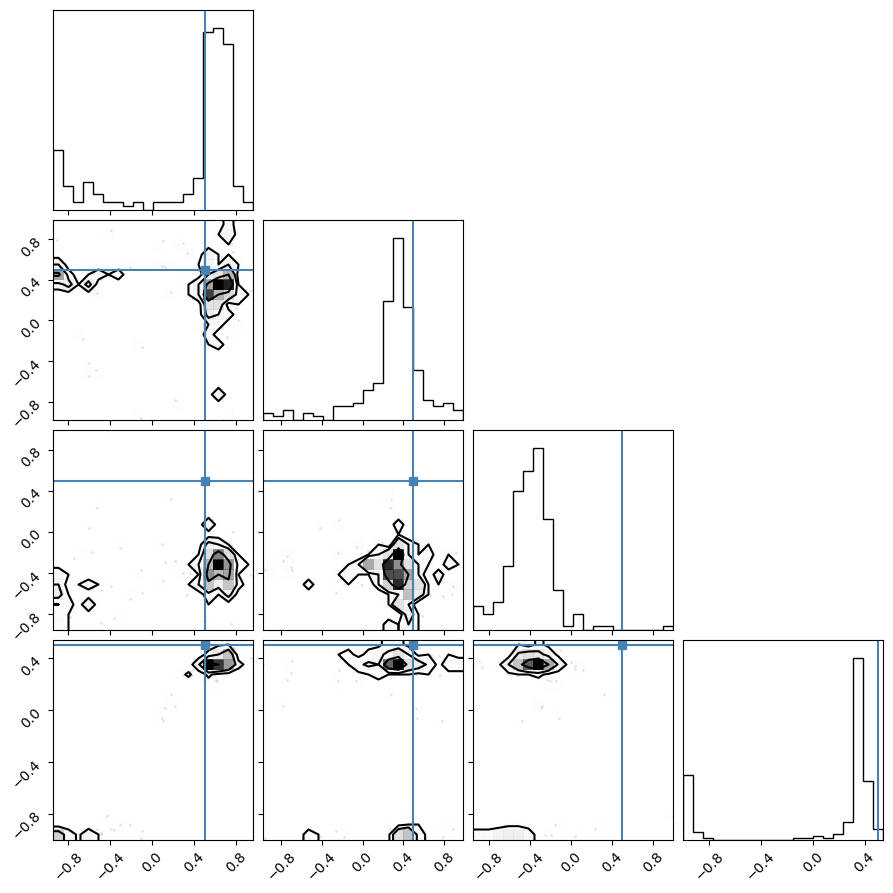

100%|██████████| 100/100 [02:29<00:00,  1.49s/it, loss=8.99, T=1]


Done!


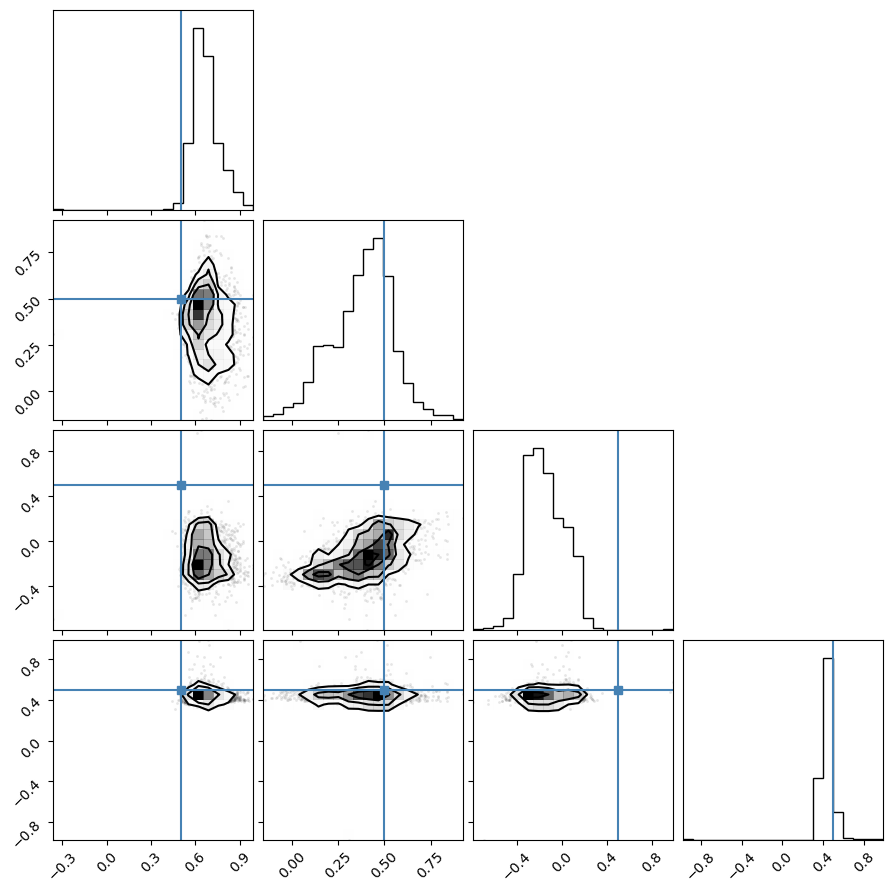

In [66]:
n_params = 4
flow_num_layers = 4
hidden_size = 16
mlp_num_layers = 2
num_bins = 4


# perform variational inference
epochs = 100
loss = dict(train=[], val=[])
Nsamps = 20

learning_rate = 0.01
optimiser = optax.adam(learning_rate)              #stochastic gradient descent 

prng_seq = hk.PRNGSequence(42)
key = next(prng_seq)
params = sample_and_log_prob.init(key, prng_key=key, n=Nsamps)
opt_state = optimiser.init(params)

from tqdm import tqdm, trange
   
ldict = dict(loss = 0, T=1)

log_l = LogL(true_params)         

with trange(epochs) as tepochs:
    for epoch in tepochs:
  
        #update NN params (stochastic gradient descent with Adam optimiser)
        prng_key = next(prng_seq)
        loss = loss_fn(params,  prng_key, Nsamps)
        ldict['loss'] = f'{loss:.2f}'
        tepochs.set_postfix(ldict, refresh=True)
        params, opt_state = update(params, prng_key, opt_state)        #take a step in direction of stepest descent (negative gradient)
            
            
        #print results every 50 iterations
        if epoch%50 == 0:
            print(f'Epoch {epoch}, loss {loss}')
            x_gen, log_prob_gen = sample_and_log_prob.apply(params, next(prng_seq), 10*Nsamps)
            x_gen = np.array(x_gen, copy=False)
            p_gen = np.vstack(list(log_l.array_to_phys(x_gen).values()))
            truths = [log_l.true_gw_params[n] for n in ['A','ra','dec','psi']]
            fig = corner.corner(p_gen.T, truths = truths)
            plt.show()

print("Done!")

x_gen, log_prob_gen = sample_and_log_prob.apply(params, next(prng_seq), 100*Nsamps)

x_gen = np.array(x_gen, copy=False)
p_gen = np.vstack(list(log_l.array_to_phys(x_gen).values()))
truths = [log_l.true_gw_params[n] for n in ['A','ra','dec','psi']]
fig = corner.corner(p_gen.T, truths = truths)
plt.show()

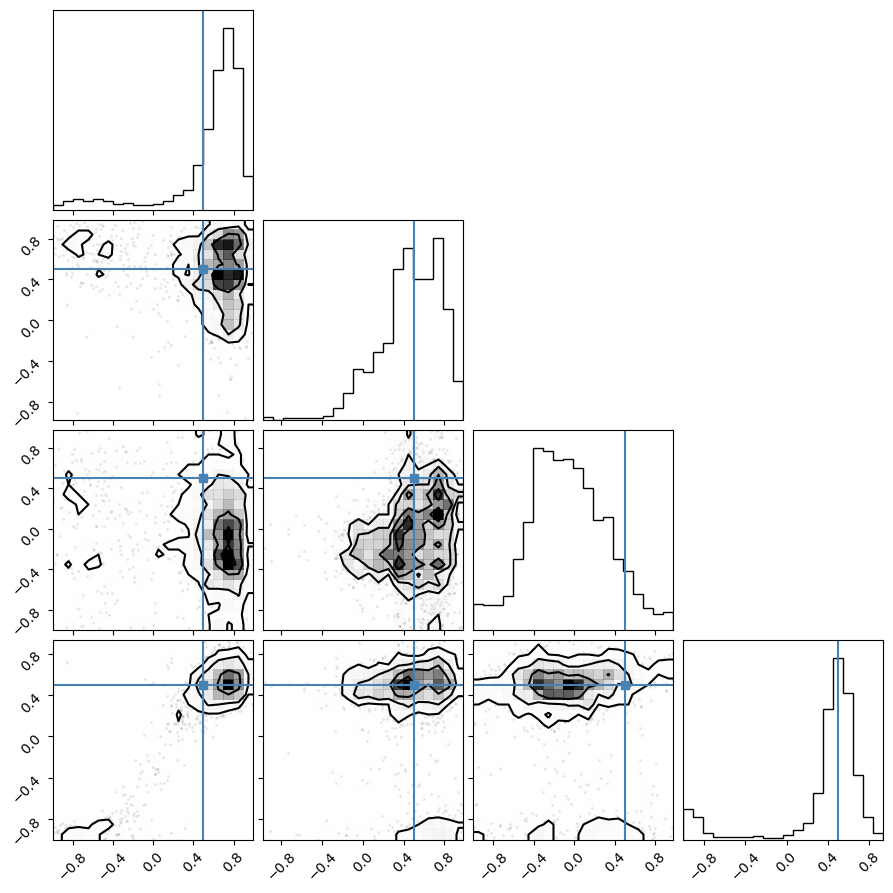

In [32]:
x_gen, log_prob_gen = sample_and_log_prob.apply(params, next(prng_seq), 100*Nsamps)

x_gen = np.array(x_gen, copy=False)
p_gen = np.vstack(list(log_l.array_to_phys(x_gen).values()))
truths = [log_l.true_gw_params[n] for n in ['A','ra','dec','psi']]
fig = corner.corner(p_gen.T, truths = truths)
plt.show()

In [58]:
x, logq = sample_and_log_prob.apply(params, prng_key, 100)
p = log_l.array_to_phys(x)
#log_l(true_params)
log_p = log_likelihood(x)

(2, 100, 11)


In [63]:
jax.grad(loss_fn)(params, prng_key, Nsamps)

(2, 100, 11)


{'linear': {'b': Array([-28.89107147,  -3.12075468,  10.31195345,  21.6998727 ,
          28.68396276,   3.32506569, -10.33961353, -21.66941492,
           1.86867593,  -0.25078609,  -0.34760157,   0.18314144,
          -0.59244133,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ,  -2.52900324,   1.00990476,
           2.44961439,  -0.93051591,   2.5566856 ,  -0.98532335,
          -2.48836549,   0.91700324,  -0.03645522,   0.04743403,
          -0.03587191,  -0.22996395,   0.26487596,   0.        ,
           0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ,   0.        ,   0.        ],      dtype=float64),
  'w': Array([[-3.99771881e+00, -3.16948517e-01,  1.36535356e+00,
           2.94931377e+00,  4.02344041e+00,  3.41358

In [111]:
log_p

Array([-1963.16170248, -1864.66470912, -2014.01233397, -1863.02155001,
       -1914.90250749, -1635.20386367, -1905.34486443, -1872.87297499,
       -2211.41056864, -1897.25521234, -1409.00306144, -1926.53372847,
       -1788.88539086, -2042.08323798, -1600.24469784, -1961.53774286,
       -2456.07821915, -2330.47244915, -1667.5438362 , -1943.67664555,
       -1815.29263718, -2289.55246946, -1867.4849457 , -1754.86763121,
       -1771.47001435, -2163.10767421, -1915.56176267, -1821.34077963,
       -1846.64400743, -1536.59863802, -1897.84123747, -2371.97998142,
       -2216.66019962, -1877.65198027, -1920.601581  , -1984.6454449 ,
       -2071.36531532, -2042.69725288, -1852.45495113, -2044.91663044,
       -2115.69343969, -1894.78348468, -1886.93491423, -1887.98656739,
       -2109.08252419, -2146.79180769, -1968.32956493, -1812.41958902,
       -2327.97820778, -1928.03804809, -2154.40818112, -1917.21695365,
       -1902.10906187, -1907.17990186, -1652.02956958, -1693.65706888,
      

In [42]:
log_l.array_to_phys(x)

{'A': Array([-0.5431577 ,  0.05269671, -0.7512385 ,  0.92817978], dtype=float64),
 'ra': Array([ 0.96932533, -0.35087918, -0.58273929,  0.80927816], dtype=float64),
 'dec': Array([-0.3475862 ,  0.71124451,  0.35995947, -0.15062909], dtype=float64),
 'psi': Array([ 0.71317518, -0.23725713, -0.22994588,  0.6349227 ], dtype=float64)}

In [88]:
log_p

Array([[ -14.13137282,  -26.12440223, -125.11829484, ...,   -9.05053201,
          -4.80929753,   -3.85251234],
       [ -12.31226484,  -23.0893185 , -112.31161777, ...,   -8.04464716,
          -4.26448097,   -3.44516417],
       [ -13.82721779,  -25.61591671, -122.96701068, ...,   -8.88062842,
          -4.71603634,   -3.78088427],
       ...,
       [ -12.3528805 ,  -23.15679381, -112.59471101, ...,   -8.06661699,
          -4.27602899,   -3.45325869],
       [ -14.04694178,  -25.98322753, -124.52088828, ...,   -9.0033291 ,
          -4.78335978,   -3.83254911],
       [ -13.66322418,  -25.34185721, -121.80811279, ...,   -8.78919661,
          -4.66597438,   -3.74262507]], dtype=float64)